<a href="https://colab.research.google.com/github/Randon-Myntra-HackerRamp-21/Skin-type/blob/main/Skin_types%20Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import splitfolders

In [4]:
splitfolders.ratio(r'.\skin_images', output="output", seed=1337, ratio=(.8, 0.2)) 

In [5]:
def filter_hidden_directories(directory):
    return [subdir for subdir in os.listdir(directory) if not subdir.startswith('.')]

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = 'output/train'
test_dir = 'output/val'

# Filter hidden directories
filtered_train_dirs = filter_hidden_directories(train_dir)
filtered_test_dirs = filter_hidden_directories(test_dir)

# Import data from filtered directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               classes=filtered_train_dirs,
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               classes=filtered_test_dirs,
                                               class_mode="categorical",
                                               seed=42)

Found 21 images belonging to 3 classes.
Found 7 images belonging to 3 classes.


In [8]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url, num_classes=3):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default = 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,   # freeze the already learned patterns
                                           name="EfficientnetB0_model",
                                           input_shape=IMAGE_SHAPE+(3,))  # define the input image shape
  # Create our image model
  model = tf.keras.Sequential([
    feature_extractor_layer,    # use the feature extraction layer as the base
    layers.Dense(num_classes, activation="softmax", name="output_layer")   # create our own output layer
  ])
  return model

In [9]:
# Create EfficientNet model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=3)
# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [10]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientnetB0_model (Kera  (None, 1280)              4049564   
 sLayer)                                                         
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4053407 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [11]:
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=valid_data)   # name of log files

Epoch 1/5
1/1 [==============================] - 12s 12s/step - loss: 1.1619 - accuracy: 0.3125 - val_loss: 0.8142 - val_accuracy: 0.6000
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 1.0612 - accuracy: 0.5625 - val_loss: 0.7665 - val_accuracy: 0.8000
Epoch 3/5
1/1 [==============================] - 1s 814ms/step - loss: 0.9742 - accuracy: 0.6875 - val_loss: 0.7302 - val_accuracy: 0.8000
Epoch 4/5
1/1 [==============================] - 1s 780ms/step - loss: 0.8983 - accuracy: 0.7500 - val_loss: 0.7024 - val_accuracy: 0.8000
Epoch 5/5
1/1 [==============================] - 1s 763ms/step - loss: 0.8310 - accuracy: 0.7500 - val_loss: 0.6804 - val_accuracy: 0.8000


In [12]:
efficientnet_model.save('saved_model/skin_model')

INFO:tensorflow:Assets written to: saved_model/skin_model\assets


INFO:tensorflow:Assets written to: saved_model/skin_model\assets


In [2]:
model = tf.keras.models.load_model(r'C:\Users\imana\CW AI\Skyn\application\models\skin_model')

# Check its architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4053407 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [6]:
import pathlib 
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['dry' 'normal' 'oily']


In [7]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [8]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model
    and plots the image with the predicted class as the title.
    """
    try:
        # Import the target image and preprocess it
        img = load_and_prep_image(filename)

        # Make a prediction
        pred = model.predict(tf.expand_dims(img, axis=0))

        # Add in logic for multi-class & get pred_class name
        if len(pred[0]) > 1:
            pred_class = class_names[tf.argmax(pred[0])]
        else:
            pred_class = class_names[int(tf.round(pred[0]))]

        print('Prediction Probabilities: ', pred[0])

        # Plot the image and predicted class
        plt.imshow(img)
        plt.title(f"Prediction: {pred_class}")
        plt.axis(False)
    except FileNotFoundError:
        print('File not found:', filename)
    except Exception as e:
        print('Error:', e)

1/1 [==============================] - 2s 2s/step
Prediction Probabilities:  [0.36729953 0.14636178 0.48633868]


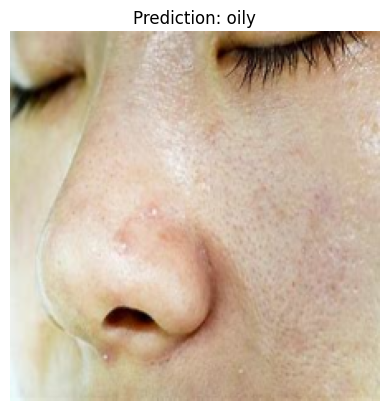

In [9]:
# Make a prediction using model_1
pred_and_plot(model=model, 
              filename= r"C:\Users\imana\CW AI\Skyn\ML\Skin_metrics\Skin_type\skin_images\oily\2.jpeg", 
              class_names=class_names)